
<a id='discrete-dp'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Discrete State Dynamic Programming

## Contents

- [Discrete State Dynamic Programming](#Discrete-State-Dynamic-Programming)  
  - [Overview](#Overview)  
  - [Discrete DPs](#Discrete-DPs)  
  - [Solving Discrete DPs](#Solving-Discrete-DPs)  
  - [Example: A Growth Model](#Example:-A-Growth-Model)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  
  - [Appendix: Algorithms](#Appendix:-Algorithms)  

## Overview

In this lecture we discuss a family of dynamic programming problems with the following features:

1. a discrete state space and discrete choices (actions)  
1. an infinite horizon  
1. discounted rewards  
1. Markov state transitions  


We call such problems discrete dynamic programs, or discrete DPs.

Discrete DPs are the workhorses in much of modern quantitative economics, including

- monetary economics  
- search and labor economics  
- household savings and consumption theory  
- investment theory  
- asset pricing  
- industrial organization, etc.  


When a given model is not inherently discrete, it is common to replace it with a discretized version in order to use discrete DP techniques.

This lecture covers

- the theory of dynamic programming in a discrete setting, plus examples and
  applications  
- a powerful set of routines for solving discrete DPs from the [QuantEcon code libary](http://quantecon.org/quantecon-jl)  

### How to Read this Lecture

We use dynamic programming many applied lectures, such as

- The [shortest path lecture](short_path.html)  
- The [McCall search model lecture](mccall_model.html)  
- The [optimal growth lecture](optgrowth.html)  


The objective of this lecture is to provide a more systematic and theoretical treatment, including algorithms and implementation, while focusing on the discrete case.

### References

For background reading on dynamic programming and additional applications, see, for example,

- [[LS18]](../zreferences.html#ljungqvist2012)  
- [[HLL96]](../zreferences.html#hernandezlermalasserre1996), section 3.5  
- [[Put05]](../zreferences.html#puterman2005)  
- [[SLP89]](../zreferences.html#stokeylucas1989)  
- [[Rus96]](../zreferences.html#rust1996)  
- [[MF02]](../zreferences.html#mirandafackler2002)  
- [EDTC](http://johnstachurski.net/edtc.html), chapter 5  



<a id='discrete-dps'></a>

## Discrete DPs

Loosely speaking, a discrete DP is a maximization problem with an objective
function of the form


<a id='equation-dp-objective'></a>
$$
\mathbb{E}
\sum_{t = 0}^{\infty} \beta^t r(s_t, a_t) \tag{1}
$$

where

- $ s_t $ is the state variable  
- $ a_t $ is the action  
- $ \beta $ is a discount factor  
- $ r(s_t, a_t) $ is interpreted as a current reward when the state is $ s_t $ and the action chosen is $ a_t $  


Each pair $ (s_t, a_t) $ pins down transition probabilities $ Q(s_t, a_t, s_{t+1}) $ for the next period state $ s_{t+1} $.

Thus, actions influence not only current rewards but also the future time path of the state.

The essence of dynamic programming problems is to trade off current rewards
vs favorable positioning of the future state (modulo randomness).

Examples:

- consuming today vs saving and accumulating assets  
- accepting a job offer today vs seeking a better one in the future  
- exercising an option now vs waiting  

### Policies

The most fruitful way to think about solutions to discrete DP problems is to compare *policies*.

In general, a policy is a randomized map from past actions and states to
current action.

In the setting formalized below, it suffices to consider so-called *stationary Markov policies*, which consider only the current state.

In particular, a stationary Markov policy is a map $ \sigma $ from states to actions

- $ a_t = \sigma(s_t) $ indicates that $ a_t $ is the action to be taken in state $ s_t $  


It is known that, for any arbitrary policy, there exists a stationary Markov policy that dominates it at least weakly.

- See section 5.5 of [[Put05]](../zreferences.html#puterman2005) for discussion and proofs.  


In what follows, stationary Markov policies are referred to simply as policies.

The aim is to find an optimal policy, in the sense of one that maximizes [(1)](#equation-dp-objective).

Let’s now step through these ideas more carefully.

### Formal definition

Formally, a discrete dynamic program consists of the following components:

1. A finite set of *states* $ S = \{0, \ldots, n-1\} $  
1. A finite set of *feasible actions* $ A(s) $ for each state $ s \in S $, and a corresponding set of *feasible state-action pairs*  
  
  $$
  \mathit{SA} := \{(s, a) \mid s \in S, \; a \in A(s)\}
  $$
  
1. A *reward function* $ r\colon \mathit{SA} \to \mathbb{R} $  
1. A *transition probability function* $ Q\colon \mathit{SA} \to \Delta(S) $, where $ \Delta(S) $ is the set of probability distributions over $ S $  
1. A *discount factor* $ \beta \in [0, 1) $  


We also use the notation $ A := \bigcup_{s \in S} A(s) = \{0, \ldots, m-1\} $ and call this set the *action space*.

A *policy* is a function $ \sigma\colon S \to A $.

A policy is called *feasible* if it satisfies $ \sigma(s) \in A(s) $ for all $ s \in S $.

Denote the set of all feasible policies by $ \Sigma $.

If a decision maker uses  a policy $ \sigma \in \Sigma $, then

- the current reward at time $ t $ is $ r(s_t, \sigma(s_t)) $  
- the probability that $ s_{t+1} = s' $ is $ Q(s_t, \sigma(s_t), s') $  


For each $ \sigma \in \Sigma $, define

- $ r_{\sigma} $ by $ r_{\sigma}(s) := r(s, \sigma(s)) $)  
- $ Q_{\sigma} $ by $ Q_{\sigma}(s, s') := Q(s, \sigma(s), s') $  


Notice that $ Q_\sigma $ is a [stochastic matrix](../tools_and_techniques/finite_markov.html#finite-dp-stoch-mat) on $ S $.

It gives transition probabilities of the *controlled chain* when we follow policy $ \sigma $.

If we think of $ r_\sigma $ as a column vector, then so is $ Q_\sigma^t r_\sigma $, and the $ s $-th row of the latter has the interpretation


<a id='equation-ddp-expec'></a>
$$
(Q_\sigma^t r_\sigma)(s) = \mathbb E [ r(s_t, \sigma(s_t)) \mid s_0 = s ]
\quad \text{when } \{s_t\} \sim Q_\sigma \tag{2}
$$

Comments

- $ \{s_t\} \sim Q_\sigma $ means that the state is generated by stochastic matrix $ Q_\sigma $  
- See [this discussion](../tools_and_techniques/finite_markov.html#finite-mc-expec) on computing expectations of Markov chains for an explanation of the expression in [(2)](#equation-ddp-expec)  


Notice that we’re not really distinguishing between functions from $ S $ to $ \mathbb R $ and vectors in $ \mathbb R^n $.

This is natural because they are in one to one correspondence.

### Value and Optimality

Let $ v_{\sigma}(s) $ denote the discounted sum of expected reward flows from policy $ \sigma $
when the initial state is $ s $.

To calculate this quantity we pass the expectation through the sum in
[(1)](#equation-dp-objective) and use [(2)](#equation-ddp-expec) to get

$$
v_{\sigma}(s) = \sum_{t=0}^{\infty} \beta^t (Q_{\sigma}^t r_{\sigma})(s)
\qquad (s \in S)
$$

This function is called the *policy value function* for the policy $ \sigma $.

The *optimal value function*, or simply *value function*, is the function $ v^*\colon S \to \mathbb{R} $ defined by

$$
v^*(s) = \max_{\sigma \in \Sigma} v_{\sigma}(s)
\qquad (s \in S)
$$

(We can use max rather than sup here because the domain is a finite set)

A policy $ \sigma \in \Sigma $ is called *optimal* if $ v_{\sigma}(s) = v^*(s) $ for all $ s \in S $.

Given any $ w \colon S \to \mathbb R $, a policy $ \sigma \in \Sigma $ is called $ w $-greedy if

$$
\sigma(s) \in \operatorname*{arg\,max}_{a \in A(s)}
\left\{
    r(s, a) +
    \beta \sum_{s' \in S} w(s') Q(s, a, s')
\right\}
\qquad (s \in S)
$$

As discussed in detail below, optimal policies are precisely those that are $ v^* $-greedy.

### Two Operators

It is useful to define the following operators:

- The *Bellman operator* $ T\colon \mathbb{R}^S \to \mathbb{R}^S $
  is defined by  


$$
(T v)(s) = \max_{a \in A(s)}
\left\{
    r(s, a) + \beta \sum_{s' \in S} v(s') Q(s, a, s')
\right\}
\qquad (s \in S)
$$

- For any policy function $ \sigma \in \Sigma $, the operator $ T_{\sigma}\colon \mathbb{R}^S \to \mathbb{R}^S $ is defined by  


$$
(T_{\sigma} v)(s) = r(s, \sigma(s)) +
    \beta \sum_{s' \in S} v(s') Q(s, \sigma(s), s')
\qquad (s \in S)
$$

This can be written more succinctly in operator notation as

$$
T_{\sigma} v = r_{\sigma} + \beta Q_{\sigma} v
$$

The two operators are both monotone

- $ v \leq w $  implies $ Tv \leq Tw $ pointwise on $ S $, and
  similarly for $ T_\sigma $  


They are also contraction mappings with modulus $ \beta $

- $ \lVert Tv - Tw \rVert \leq \beta \lVert v - w \rVert $ and similarly for $ T_\sigma $, where $ \lVert \cdot\rVert $ is the max norm  


For any policy $ \sigma $, its value $ v_{\sigma} $ is the unique fixed point of $ T_{\sigma} $.

For proofs of these results and those in the next section, see, for example, [EDTC](http://johnstachurski.net/edtc.html), chapter 10.

### The Bellman Equation and the Principle of Optimality

The main principle of the theory of dynamic programming is that

- the optimal value function $ v^* $ is a unique solution to the *Bellman equation*,  
  
  $$
  v(s) = \max_{a \in A(s)} \left\{ r(s, a) + \beta \sum_{s' \in S} v(s') Q(s, a, s') \right\} \qquad (s \in S),
  $$
  
  or in other words, $ v^* $ is the unique fixed point of $ T $, and  
- $ \sigma^* $ is an optimal policy function if and only if it is $ v^* $-greedy  


By the definition of greedy policies given above, this means that

$$
\sigma^*(s) \in \operatorname*{arg\,max}_{a \in A(s)}
    \left\{
    r(s, a) + \beta \sum_{s' \in S} v^*(s') Q(s, \sigma(s), s')
    \right\}
\qquad (s \in S)
$$

## Solving Discrete DPs

Now that the theory has been set out, let’s turn to solution methods.

Code for solving discrete DPs is available in [ddp.jl](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/markov/ddp.jl) from the [QuantEcon.jl](http://quantecon.org/quantecon-jl) code library.

It implements the three most important solution methods for discrete dynamic programs, namely

- value function iteration  
- policy function iteration  
- modified policy function iteration  


Let’s briefly review these algorithms and their implementation.

### Value Function Iteration

Perhaps the most familiar method for solving all manner of dynamic programs is value function iteration.

This algorithm uses the fact that the Bellman operator $ T $ is a contraction mapping with fixed point $ v^* $.

Hence, iterative application of $ T $ to any initial function $ v^0 \colon S \to \mathbb R $ converges to $ v^* $.

The details of the algorithm can be found in [the appendix](#ddp-algorithms).

### Policy Function Iteration

This routine, also known as Howard’s policy improvement algorithm, exploits more closely the particular structure of a discrete DP problem.

Each iteration consists of

1. A policy evaluation step that computes the value $ v_{\sigma} $ of a policy $ \sigma $ by solving the linear equation $ v = T_{\sigma} v $.  
1. A policy improvement step that computes a $ v_{\sigma} $-greedy policy.  


In the current setting policy iteration computes an exact optimal policy in finitely many iterations.

- See theorem 10.2.6 of [EDTC](http://johnstachurski.net/edtc.html) for a proof  


The details of the algorithm can be found in [the appendix](#ddp-algorithms).

### Modified Policy Function Iteration

Modified policy iteration replaces the policy evaluation step in policy iteration with “partial policy evaluation”.

The latter computes an approximation to the value of a policy $ \sigma $ by iterating $ T_{\sigma} $ for a specified number of times.

This approach can be useful when the state space is very large and the linear system in the policy evaluation step of policy iteration is correspondingly difficult to solve.

The details of the algorithm can be found in [the appendix](#ddp-algorithms).


<a id='ddp-eg-gm'></a>

## Example: A Growth Model

Let’s consider a simple consumption-saving model.

A single household either consumes or stores its own output of a single consumption good.

The household starts each period with current stock $ s $.

Next, the household chooses a quantity $ a $ to store and consumes $ c = s - a $

- Storage is limited by a global upper bound $ M $  
- Flow utility is $ u(c) = c^{\alpha} $  


Output is drawn from a discrete uniform distribution on $ \{0, \ldots, B\} $.

The next period stock is therefore

$$
s' = a + U
\quad \text{where} \quad
U \sim U[0, \ldots, B]
$$

The discount factor is $ \beta \in [0, 1) $.

### Discrete DP Representation

We want to represent this model in the format of a discrete dynamic program.

To this end, we take

- the state variable to be the stock $ s $  
- the state space to be $ S = \{0, \ldots, M + B\} $  
  
  - hence $ n = M + B + 1 $  
  
- the action to be the storage quantity $ a $  
- the set of feasible actions at $ s $ to be $ A(s) = \{0, \ldots, \min\{s, M\}\} $  
  
  - hence $ A = \{0, \ldots, M\} $ and $ m = M + 1 $  
  
- the reward function to be $ r(s, a) = u(s - a) $  
- the transition probabilities to be  



<a id='equation-ddp-def-ogq'></a>
$$
Q(s, a, s')
:=
\begin{cases}
    \frac{1}{B + 1} & \text{if } a \leq s' \leq a + B
    \\
     0 & \text{ otherwise}
\end{cases} \tag{3}
$$

### Defining a DiscreteDP Instance

This information will be used to create an instance of DiscreteDP by passing
the following information

1. An $ n \times m $ reward array $ R $  
1. An $ n \times m \times n $ transition probability array $ Q $  
1. A discount factor $ \beta $  


For $ R $ we set $ R[s, a] = u(s - a) $ if $ a \leq s $ and $ -\infty $ otherwise.

For $ Q $ we follow the rule in [(3)](#equation-ddp-def-ogq).

Note:

- The feasibility constraint is embedded into $ R $ by setting $ R[s, a] = -\infty $ for $ a \notin A(s) $.  
- Probability distributions for $ (s, a) $ with $ a \notin A(s) $ can be arbitrary.  


The following code sets up these objects for us.

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.6.0")
# uncomment to force package installation and precompilation
# github_project("QuantEcon/quantecon-notebooks-julia", version="0.6.0", instantiate=true, precompile = true)

In [2]:
using LinearAlgebra, Statistics, BenchmarkTools, Plots, QuantEcon
using SparseArrays

In [3]:
using BenchmarkTools, Plots, QuantEcon, Parameters
gr(fmt = :png);

In [4]:
SimpleOG = @with_kw (B = 10, M = 5, α = 0.5, β = 0.9)

function transition_matrices(g)
    @unpack B, M, α, β = g
    u(c) = c^α
    n = B + M + 1
    m = M + 1

    R = zeros(n, m)
    Q = zeros(n, m, n)

    for a in 0:M
        Q[:, a + 1, (a:(a + B)) .+ 1] .= 1 / (B + 1)
        for s in 0:(B + M)
            R[s + 1, a + 1] = (a≤s ? u(s - a) : -Inf)
        end
    end

    return (Q = Q, R = R)
end

transition_matrices (generic function with 1 method)

Let’s run this code and create an instance of `SimpleOG`

In [5]:
g = SimpleOG();
Q, R = transition_matrices(g);

In case the preceding code was too concise, we can see a more verbose form

In [6]:
function verbose_matrices(g)
    @unpack B, M, α, β = g
    u(c) = c^α

    #Matrix dimensions. The +1 is due to the 0 state.
    n = B + M + 1
    m = M + 1

    R = fill(-Inf, n, m) #Start assuming nothing is feasible
    Q = zeros(n,m,n) #Assume 0 by default

    #Create the R matrix
    #Note: indexing into matrix complicated since Julia starts indexing at 1 instead of 0
    #but the state s and choice a can be 0
    for a in 0:M
         for s in 0:(B + M)
            if a <= s #i.e. if feasible
                R[s + 1, a + 1] = u(s - a)
            end
        end
    end

    #Create the Q multi-array
    for s in 0:(B+M) #For each state
        for a in 0:M #For each action
            for sp in 0:(B+M) #For each state next period
                if( sp >= a && sp <= a + B) # The support of all realizations
                    Q[s + 1, a + 1, sp + 1] = 1 / (B + 1) # Same prob of all
                end
            end
            @assert sum(Q[s + 1, a + 1, :]) ≈ 1 #Optional check that matrix is stochastic
         end
    end
    return (Q = Q, R = R)
end

verbose_matrices (generic function with 1 method)

Instances of `DiscreteDP` are created using the signature `DiscreteDP(R, Q, β)`.

Let’s create an instance using the objects stored in `g`

In [7]:
ddp = DiscreteDP(R, Q, g.β);

Now that we have an instance `ddp` of `DiscreteDP` we can solve it as follows

In [8]:
results = solve(ddp, PFI)

QuantEcon.DPSolveResult{PFI,Float64}([19.01740221695992, 20.017402216959916, 20.431615779333015, 20.749453024528794, 21.040780991093488, 21.30873018352461, 21.544798161024403, 21.76928181079986, 21.982703576083246, 22.1882432282385, 22.384504796519916, 22.578077363861723, 22.761091269771118, 22.943767083452716, 23.115339958706524, 23.277617618874903], [19.01740221695992, 20.01740221695992, 20.431615779333015, 20.749453024528798, 21.040780991093488, 21.30873018352461, 21.5447981610244, 21.769281810799864, 21.982703576083253, 22.1882432282385, 22.38450479651991, 22.578077363861723, 22.761091269771114, 22.943767083452716, 23.115339958706524, 23.277617618874903], 3, [1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6], Discrete Markov Chain
stochastic matrix of type Adjoint{Float64,Array{Float64,2}}:
[0.09090909090909091 0.09090909090909091 … 0.0 0.0; 0.09090909090909091 0.09090909090909091 … 0.0 0.0; … ; 0.0 0.0 … 0.09090909090909091 0.09090909090909091; 0.0 0.0 … 0.09090909090909091 0.090909

Let’s see what we’ve got here

In [9]:
fieldnames(typeof(results))

(:v, :Tv, :num_iter, :sigma, :mc)

The most important attributes are `v`, the value function, and `σ`, the optimal policy

In [10]:
results.v

16-element Array{Float64,1}:
 19.01740221695992
 20.017402216959916
 20.431615779333015
 20.749453024528794
 21.040780991093488
 21.30873018352461
 21.544798161024403
 21.76928181079986
 21.982703576083246
 22.1882432282385
 22.384504796519916
 22.578077363861723
 22.761091269771118
 22.943767083452716
 23.115339958706524
 23.277617618874903

In [11]:
results.sigma .- 1

16-element Array{Int64,1}:
 0
 0
 0
 0
 1
 1
 1
 2
 2
 3
 3
 4
 5
 5
 5
 5

Here 1 is subtracted from results.sigma because we added 1 to each state and action to create valid indices.

Since we’ve used policy iteration, these results will be exact unless we hit the iteration bound `max_iter`.

Let’s make sure this didn’t happen

In [12]:
results.num_iter

3

In this case we converged in only 3 iterations.

Another interesting object is `results.mc`, which is the controlled chain defined by $ Q_{\sigma^*} $, where $ \sigma^* $ is the optimal policy.

In other words, it gives the dynamics of the state when the agent follows the optimal policy.

Since this object is an instance of MarkovChain from  [QuantEcon.jl](http://quantecon.org/quantecon-jl) (see [this lecture](../tools_and_techniques/finite_markov.html) for more discussion), we
can easily simulate it, compute its stationary distribution and so on

In [13]:
stationary_distributions(results.mc)[1]

16-element Array{Float64,1}:
 0.01732186732186732
 0.041210632119723034
 0.05773955773955773
 0.07426848335939244
 0.08095823095823096
 0.09090909090909091
 0.0909090909090909
 0.0909090909090909
 0.09090909090909093
 0.09090909090909091
 0.09090909090909091
 0.0735872235872236
 0.049698458789367884
 0.033169533169533166
 0.016640607549698462
 0.009950859950859951

Here’s the same information in a bar graph

<img src="_static/figures/finite_dp_simple_og.png" style="width:80%;">

  
What happens if the agent is more patient?

In [14]:
g_2 = SimpleOG(β=0.99);
Q_2, R_2 = transition_matrices(g_2);

ddp_2 = DiscreteDP(R_2, Q_2, g_2.β)

results_2 = solve(ddp_2, PFI)

std_2 = stationary_distributions(results_2.mc)[1]

16-element Array{Float64,1}:
 0.005469129800680602
 0.023213417598444343
 0.03147788040836169
 0.04800680602819641
 0.056271268838113765
 0.09090909090909091
 0.09090909090909093
 0.09090909090909093
 0.09090909090909094
 0.09090909090909093
 0.09090909090909094
 0.0854399611084103
 0.06769567331064659
 0.059431210500729234
 0.042902284880894495
 0.03463782207097716

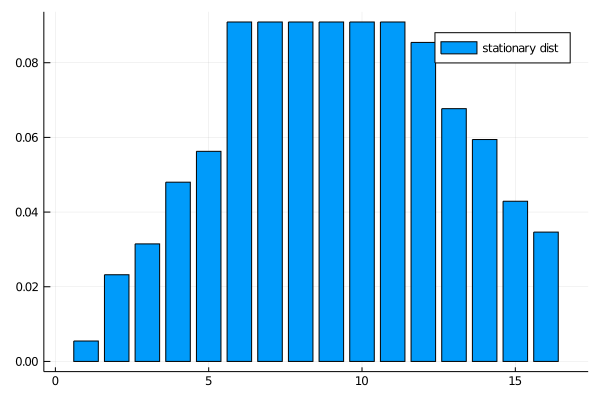

In [15]:
bar(std_2, label = "stationary dist")

We can see the rightward shift in probability mass.

### State-Action Pair Formulation

The `DiscreteDP` type in fact provides a second interface to setting up an instance.

One of the advantages of this alternative set up is that it permits use of a sparse matrix for `Q`.

(An example of using sparse matrices is given in the exercises below)

The call signature of the second formulation is `DiscreteDP(R, Q, β, s_indices, a_indices)` where

- `s_indices` and `a_indices` are arrays of equal length `L` enumerating all feasible state-action pairs  
- `R` is an array of length `L` giving corresponding rewards  
- `Q` is an `L x n` transition probability array  


Here’s how we could set up these objects for the preceding example

In [16]:
B = 10
M = 5
α = 0.5
β = 0.9
u(c) = c^α
n = B + M + 1
m = M + 1

s_indices = Int64[]
a_indices = Int64[]
Q = zeros(0, n)
R = zeros(0)

b = 1 / (B + 1)

for s in 0:(M + B)
    for a in 0:min(M, s)
        s_indices = [s_indices; s + 1]
        a_indices = [a_indices; a + 1]
        q = zeros(1, n)
        q[(a + 1):((a + B) + 1)] .= b
        Q = [Q; q]
        R = [R; u(s-a)]
    end
end

ddp = DiscreteDP(R, Q, β, s_indices, a_indices);
results = solve(ddp, PFI)

QuantEcon.DPSolveResult{PFI,Float64}([19.01740221695992, 20.017402216959916, 20.431615779333015, 20.749453024528794, 21.040780991093488, 21.30873018352461, 21.544798161024403, 21.76928181079986, 21.982703576083246, 22.1882432282385, 22.384504796519916, 22.578077363861723, 22.761091269771118, 22.943767083452716, 23.115339958706524, 23.277617618874903], [19.01740221695992, 20.01740221695992, 20.431615779333015, 20.749453024528798, 21.040780991093488, 21.30873018352461, 21.5447981610244, 21.769281810799864, 21.982703576083253, 22.1882432282385, 22.38450479651991, 22.578077363861723, 22.761091269771114, 22.943767083452716, 23.115339958706524, 23.277617618874903], 3, [1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6], Discrete Markov Chain
stochastic matrix of type Array{Float64,2}:
[0.09090909090909091 0.09090909090909091 … 0.0 0.0; 0.09090909090909091 0.09090909090909091 … 0.0 0.0; … ; 0.0 0.0 … 0.09090909090909091 0.09090909090909091; 0.0 0.0 … 0.09090909090909091 0.09090909090909091])

## Exercises

In the stochastic optimal growth lecture [dynamic programming lecture](optgrowth.html), we solve a
[benchmark model](optgrowth.html#benchmark-growth-mod) that has an analytical solution to check we could replicate it numerically.

The exercise is to replicate this solution using `DiscreteDP`.

## Solutions

These were written jointly by Max Huber and Daisuke Oyama.

### Setup

Details of the model can be found in [the
lecture](https://julia.quantecon.org/dynamic_programming/optgrowth.html). As in the lecture,
we let $ f(k) = k^{\alpha} $ with $ \alpha = 0.65 $,
$ u(c) = \log c $, and $ \beta = 0.95 $.

In [17]:
α = 0.65
f(k) = k.^α
u_log(x) = log(x)
β = 0.95

0.95

Here we want to solve a finite state version of the continuous state
model above. We discretize the state space into a grid of size
`grid_size = 500`, from $ 10^{-6} $ to `grid_max=2`.

In [18]:
grid_max = 2
grid_size = 500
grid = range(1e-6, grid_max, length = grid_size)

1.0e-6:0.004008014028056112:2.0

We choose the action to be the amount of capital to save for the next
period (the state is the capital stock at the beginning of the period).
Thus the state indices and the action indices are both `1`, …,
`grid_size`. Action (indexed by) `a` is feasible at state (indexed
by) `s` if and only if `grid[a] < f([grid[s])` (zero consumption is
not allowed because of the log utility).

Thus the Bellman equation is:

$$
v(k) = \max_{0 < k' < f(k)} u(f(k) - k') + \beta v(k'),
$$

where $ k^{\prime} $ is the capital stock in the next period.

The transition probability array `Q` will be highly sparse (in fact it
is degenerate as the model is deterministic), so we formulate the
problem with state-action pairs, to represent `Q` in sparse matrix
format.

We first construct indices for state-action pairs:

In [19]:
C = f.(grid) .- grid'
coord = repeat(collect(1:grid_size), 1, grid_size) #coordinate matrix
s_indices = coord[C .> 0]
a_indices = transpose(coord)[C .> 0]
L = length(a_indices)

118841

Now let’s set up $ R $ and $ Q $

In [20]:
R = u_log.(C[C.>0]);

In [21]:
using SparseArrays

Q = spzeros(L, grid_size) # Formerly spzeros

for i in 1:L
    Q[i, a_indices[i]] = 1
end

We’re now in a position to create an instance of `DiscreteDP`
corresponding to the growth model.

In [22]:
ddp = DiscreteDP(R, Q, β, s_indices, a_indices);

### Solving the Model

In [23]:
results = solve(ddp, PFI)
v, σ, num_iter = results.v, results.sigma, results.num_iter
num_iter

10

Let us compare the solution of the discrete model with the exact
solution of the original continuous model. Here’s the exact solution:

In [24]:
c = f(grid) - grid[σ]

ab = α * β
c1 = (log(1 - α * β) + log(α * β) * α * β / (1 - α * β)) / (1 - β)
c2 = α / (1 - α * β)

v_star(k) = c1 + c2 * log(k)
c_star(k) = (1 - α * β) * k.^α

c_star (generic function with 1 method)

Let’s plot the value functions.

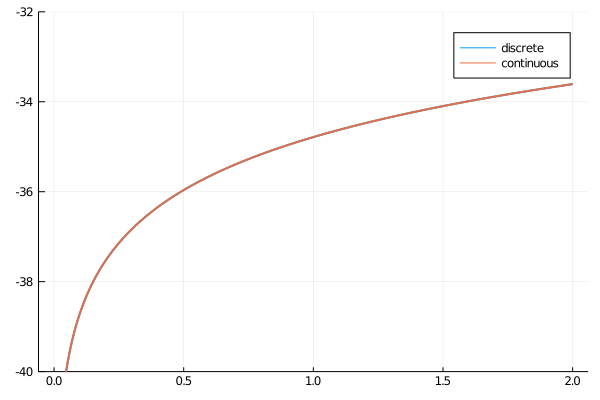

In [25]:
plot(grid, [v v_star.(grid)], ylim = (-40, -32), lw = 2, label = ["discrete" "continuous"])

They are barely distinguishable (although you can see the difference if
you zoom).

Now let’s look at the discrete and exact policy functions for
consumption.

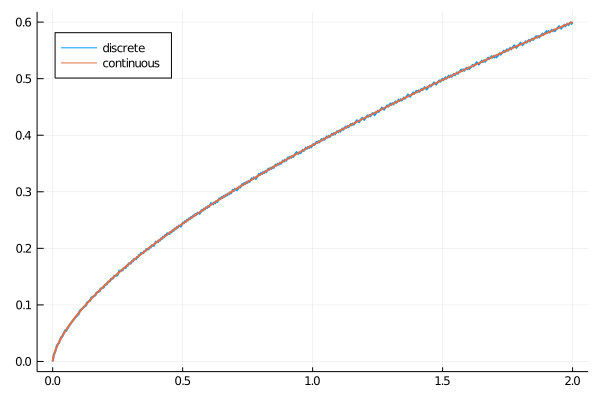

In [26]:
plot(grid, [c c_star.(grid)], lw = 2, label = ["discrete" "continuous"], legend = :topleft)

These functions are again close, although some difference is visible and
becomes more obvious as you zoom. Here are some statistics:

In [27]:
maximum(abs(x - v_star(y)) for (x, y) in zip(v, grid))

121.49819147053378

This is a big error, but most of the error occurs at the lowest
gridpoint. Otherwise the fit is reasonable:

In [28]:
maximum(abs(v[idx] - v_star(grid[idx])) for idx in 2:lastindex(v))

0.012681735127500815

The value function is monotone, as expected:

In [29]:
all(x -> x ≥ 0, diff(v))

true

### Comparison of the solution methods

Let’s try different solution methods. The results below show that policy
function iteration and modified policy function iteration are much
faster that value function iteration.

In [30]:
@benchmark results = solve(ddp, PFI)
results = solve(ddp, PFI);

In [31]:
@benchmark res1 = solve(ddp, VFI, max_iter = 500, epsilon = 1e-4)
res1 = solve(ddp, VFI, max_iter = 500, epsilon = 1e-4);

In [32]:
res1.num_iter

294

In [33]:
σ == res1.sigma

true

In [34]:
@benchmark res2 = solve(ddp, MPFI, max_iter = 500, epsilon = 1e-4)
res2 = solve(ddp, MPFI, max_iter = 500, epsilon = 1e-4);

In [35]:
res2.num_iter

16

In [36]:
σ == res2.sigma

true

### Replication of the figures

Let’s visualize convergence of value function iteration, as in the
lecture.

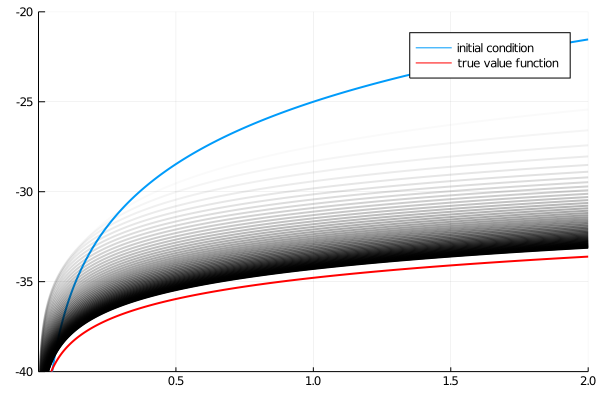

In [37]:
w_init = 5log.(grid) .- 25  # Initial condition
n = 50

ws = []
colors = []
w = w_init
for i in 0:n-1
    w = bellman_operator(ddp, w)
    push!(ws, w)
    push!(colors, RGBA(0, 0, 0, i/n))
end

plot(grid,
     w_init,
     ylims = (-40, -20),
     lw = 2,
     xlims = extrema(grid),
     label = "initial condition")

plot!(grid, ws,  label = "", color = reshape(colors, 1, length(colors)), lw = 2)
plot!(grid, v_star.(grid), label = "true value function", color = :red, lw = 2)

We next plot the consumption policies along the value iteration. First
we write a function to generate the and record the policies at given
stages of iteration.

In [38]:
function compute_policies(n_vals...)
    c_policies = []
    w = w_init
    for n in 1:maximum(n_vals)
        w = bellman_operator(ddp, w)
        if n in n_vals
            σ = compute_greedy(ddp, w)
            c_policy = f(grid) - grid[σ]
            push!(c_policies, c_policy)
        end
    end
    return c_policies
end

compute_policies (generic function with 1 method)

Now let’s generate the plots.

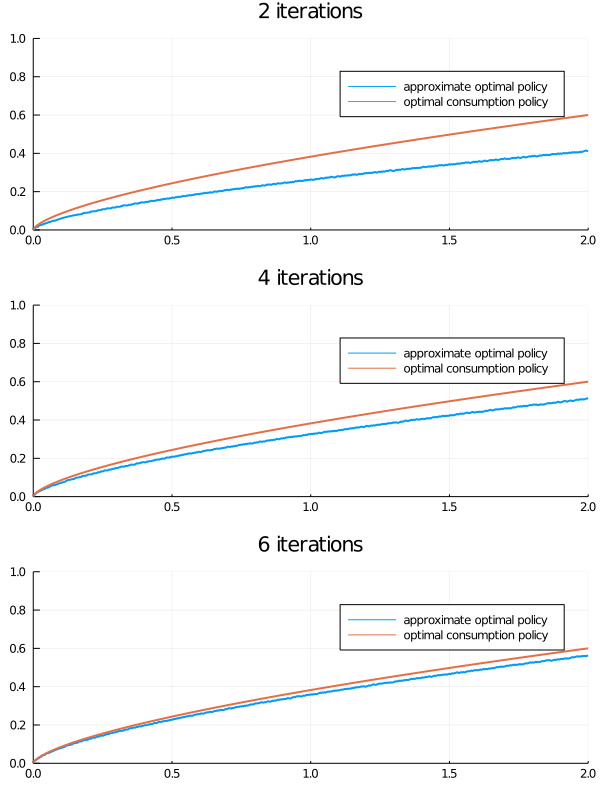

In [39]:
true_c = c_star.(grid)
c_policies = compute_policies(2, 4, 6)
plot_vecs = [c_policies[1] c_policies[2] c_policies[3] true_c true_c true_c]
l1 = "approximate optimal policy"
l2 = "optimal consumption policy"
labels = [l1 l1 l1 l2 l2 l2]
plot(grid,
     plot_vecs,
     xlim = (0, 2),
     ylim = (0, 1),
     layout = (3, 1),
     lw = 2,
     label = labels,
     size = (600, 800),
     title = ["2 iterations" "4 iterations" "6 iterations"])

### Dynamics of the capital stock

Finally, let us work on [Exercise
2](https://julia.quantecon.org/dynamic_programming/optgrowth.html#Exercise-1), where we plot
the trajectories of the capital stock for three different discount
factors, $ 0.9 $, $ 0.94 $, and $ 0.98 $, with initial
condition $ k_0 = 0.1 $.

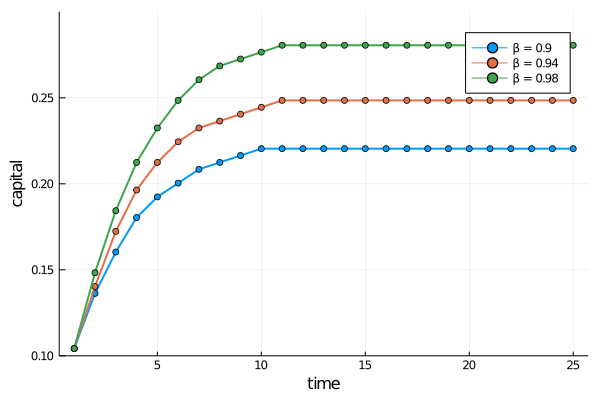

In [40]:
discount_factors = (0.9, 0.94, 0.98)
k_init = 0.1

k_init_ind = findfirst(collect(grid) .≥ k_init)

sample_size = 25

ddp0 = DiscreteDP(R, Q, β, s_indices, a_indices)
k_paths = []
labels = []

for β in discount_factors
    ddp0.beta = β
    res0 = solve(ddp0, PFI)
    k_path_ind = simulate(res0.mc, sample_size, init=k_init_ind)
    k_path = grid[k_path_ind.+1]
    push!(k_paths, k_path)
    push!(labels, "β = $β")
end

plot(k_paths,
     xlabel = "time",
     ylabel = "capital",
     ylim = (0.1, 0.3),
     lw = 2,
     markershape = :circle,
     label = reshape(labels, 1, length(labels)))


<a id='ddp-algorithms'></a>

## Appendix: Algorithms

This appendix covers the details of the solution algorithms implemented for `DiscreteDP`.

We will make use of the following notions of approximate optimality:

- For $ \varepsilon > 0 $, $ v $ is called an  $ \varepsilon $-approximation of $ v^* $ if $ \lVert v - v^*\rVert < \varepsilon $  
- A policy $ \sigma \in \Sigma $ is called $ \varepsilon $-optimal if $ v_{\sigma} $ is an $ \varepsilon $-approximation of $ v^* $  

### Value Iteration

The `DiscreteDP` value iteration method implements value function iteration as
follows

1. Choose any $ v^0 \in \mathbb{R}^n $, and specify $ \varepsilon > 0 $; set $ i = 0 $.  
1. Compute $ v^{i+1} = T v^i $.  
1. If $ \lVert v^{i+1} - v^i\rVert <  [(1 - \beta) / (2\beta)] \varepsilon $,
  then go to step 4; otherwise, set $ i = i + 1 $ and go to step 2.  
1. Compute a $ v^{i+1} $-greedy policy $ \sigma $, and return $ v^{i+1} $ and $ \sigma $.  


Given $ \varepsilon > 0 $, the value iteration algorithm

- terminates in a finite number of iterations  
- returns an $ \varepsilon/2 $-approximation of the optimal value function and an $ \varepsilon $-optimal policy function (unless `iter_max` is reached)  


(While not explicit, in the actual implementation each algorithm is
terminated if the number of iterations reaches `iter_max`)

### Policy Iteration

The `DiscreteDP` policy iteration method runs as follows

1. Choose any $ v^0 \in \mathbb{R}^n $ and compute a $ v^0 $-greedy policy $ \sigma^0 $; set $ i = 0 $.  
1. Compute the value $ v_{\sigma^i} $ by solving
  the equation $ v = T_{\sigma^i} v $.  
1. Compute a $ v_{\sigma^i} $-greedy policy
  $ \sigma^{i+1} $; let $ \sigma^{i+1} = \sigma^i $ if
  possible.  
1. If $ \sigma^{i+1} = \sigma^i $, then return $ v_{\sigma^i} $
  and $ \sigma^{i+1} $; otherwise, set $ i = i + 1 $ and go to
  step 2.  


The policy iteration algorithm terminates in a finite number of
iterations.

It returns an optimal value function and an optimal policy function (unless `iter_max` is reached).

### Modified Policy Iteration

The `DiscreteDP` modified policy iteration method runs as follows:

1. Choose any $ v^0 \in \mathbb{R}^n $, and specify $ \varepsilon > 0 $ and $ k \geq 0 $; set $ i = 0 $.  
1. Compute a $ v^i $-greedy policy $ \sigma^{i+1} $; let $ \sigma^{i+1} = \sigma^i $ if possible (for $ i \geq 1 $).  
1. Compute $ u = T v^i $ ($ = T_{\sigma^{i+1}} v^i $). If $ \mathrm{span}(u - v^i) < [(1 - \beta) / \beta] \varepsilon $, then go to step 5; otherwise go to step 4.  
  - Span is defined by $ \mathrm{span}(z) = \max(z) - \min(z) $  
1. Compute $ v^{i+1} = (T_{\sigma^{i+1}})^k u $ ($ = (T_{\sigma^{i+1}})^{k+1} v^i $); set $ i = i + 1 $ and go to step 2.  
1. Return $ v = u + [\beta / (1 - \beta)] [(\min(u - v^i) + \max(u - v^i)) / 2] \mathbf{1} $ and $ \sigma_{i+1} $.  


Given $ \varepsilon > 0 $, provided that $ v^0 $ is such that
$ T v^0 \geq v^0 $, the modified policy iteration algorithm
terminates in a finite number of iterations.

It returns an $ \varepsilon/2 $-approximation of the optimal value function and an $ \varepsilon $-optimal policy function (unless `iter_max` is reached).

See also the documentation for `DiscreteDP`.